# TensorFlow Hub ve Transferli Öğrenme

[TensorFlow Hub](http://tensorflow.org/hub), kullanabileceğimiz önceden eğitilmiş TensorFlow modellerinin çevrim içi bir deposudur. Bu modeller ya olduğu gibi kullanılabilir ya da transferli öğrenme ile modifiye ederek (güncelleyerek) kullanılabilir.

Transfer öğrenimi, mevcut bir eğitilmiş modeli aldığınız ve onu ek iş yapmak için güncellediğiniz bir süreçtir. Bu, farklı olası çıktılar elde etmek için son katmanları eklerken ve yeniden eğitirken modelin büyük kısmını değiştirmeden devam edilmesi anlamına gelir.

Bu başlık altında iki durumu da ele alacağız.

Eğer merak ediyorsanız, burada [TensorFlow Module Hub](https://tfhub.dev/). içerisinde bulunan tüm modelleri bulabilirsiniz.

## Bu Başlık Altında Değinilecek Konular

1. Tahmin için TensorFlow Hub modelinin kullanılması.
2. Dogs vs Cats veri seti için bir TensorFlow Hub modelinin kullanılması.
3. TensorFlow Hub ile basit transfer (aktarım) öğrenimi yapılması.

Bu Colab dosyasını başlatmadan önce yukarıdaki menüden `Çalışma zamanı -> Çalışma Zamanını Yeniden Başlat ...` seçeceğini seçerken colab ortamını sıfırlamalısınız.

## İçeri Aktarma İşlemleri (Imports)

Daha önceki colab dosyalarından aşina olduğumuz paketlerin içeri aktarılması. Farklı olarak yukarıda anlatılan ve bu colab dosyasında bolca kullanılacak `tensorflow_hub` paketidir.

In [12]:
import tensorflow as tf

In [13]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [14]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Bölüm 1: Tahminler İçin Bir TensorFlow Hub MobileNet Kullanımı

Kılavuzun bu bölümünde, eğitilmiş bir model alıp Keras'a yükleyeceğiz ve modeli deneyimleme fırsatı bulacağız.

Kullanacağımız model MobileNet v2'dir. (ancak [tfhub.dev'deki tf2 uyumlu görüntü sınıflandırıcı URL'inden](https://tfhub.dev/s?q=tf2&module-type=image-classification) gelen herhangi bir model de işe yarayacaktır.)

### Sınıflandırıcının İndirilmesi

MobileNet modelini indiriyoruz ve ondan bir Keras modeli oluşturuyoruz. MobileNet, 3 renk kanalında (RGB), 224 x 224 piksellik görüntüler beklemektedir.

In [15]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

### Tek Bir Görüntü Üzerinde Modeli Çalıştıralım

MobileNet, ImageNet veri seti üzerinde eğitilmiştir. ImageNet modelinin 1000 farklı çıktı sınıfı vardır ve bunlardan biri askeri üniformadır. ImageNet'in parçası olmayan bir askeri üniforma içeren bir görüntü alalım ve modelmizin bunun bir askeri üniforma olduğunu tahmin edip edemeyeceğine birlikte bakalım:

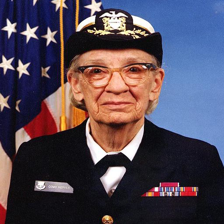

In [16]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [17]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Unutmayın, modeller her zaman işlenecek bir dizi görüntü ister. Burada bir parti (batch) boyutu ekliyoruz ve görüntüyü tahmin için modele aktarıyoruz.

In [18]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

Sonucumuz, görüntü için her sınıfın olasılığını değerlendiren 1001 elemanlı bir vektördür.

Böylece en üst sınıf kimliğini `argmax` ile bulabiliriz. Ancak bunun gerçekte hangi sınıf olduğunu ve özellikle de ImageNet veri kümesindeki bu sınıf kimliğinin bir askeri üniformaya veya başka bir şeyi ifade edip etmediğini nasıl anlayacağız?

In [19]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Tahminlerin Kodunu Çözelim (Decode)

ImageNet veri setinde tahminimiz olan `predicted_class`'ın ne olduğunu görmek için ImageNet etiketlerini indiriyioruz ve modelin tahmin ettiği gerekli satırı getiriyoruz.

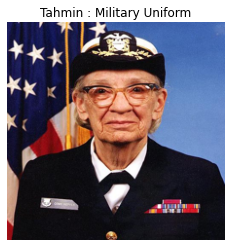

In [20]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Tahmin : " + predicted_class_name.title())

## Bölüm 2: Dogs vs Cats Veri Kümesi için TensorFlow Hub Modellerinin Kullanılması

Şimdi tam MobileNet modelini kullanacağız. Ve bu modelin daha önce üzerinde çalıştığımız kedi ve köpek görüntüleri içeren veri seti üzerinde nasıl çalıştığına göz atacağız.

### Veri Seti

`Dogs vs Cats` veri setini yüklemek için `TensorFlow Datasets` paketini kullanabiliriz.

In [21]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dogs vs. Cats veri setindeki resimlerin hepsi aynı boyutta değildir.

In [22]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


Bu nedenle tüm görüntüleri MobileNet modeli tarafından beklenen 224 x 224 çözünürlüğüne göre yeniden biçimlendirmeliyiz.



In [23]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

### Sınıflandırıcının Bir Grup Görüntü Üzerinde Çalıştırılması

Model nesnemizin hala ImageNet üzerinde eğitilmiş tam MobileNet modeli olduğunu hatırlatmakta fayda var. Bu nedenle 1000 olası çıktı sınıfına sahiptir. ImageNet içerisinde çok sayıda ledi ve köpek vardır bu yüzden bizim veri setimizdeki görüntüleri tahmin edip edemeyeceğini görelim.

In [24]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['dishwasher', 'Border collie', 'whippet', 'Persian cat',
       'cocker spaniel', 'American Staffordshire terrier', 'tabby',
       'tabby', 'tabby', 'Siamese cat', 'Border terrier', 'Border collie',
       'groenendael', 'miniature poodle', 'tabby', 'Pembroke',
       'black-footed ferret', 'schipperke', 'Chihuahua',
       'black-and-tan coonhound', 'Egyptian cat', 'Egyptian cat',
       'papillon', 'tabby', 'Persian cat', 'wire-haired fox terrier',
       'Staffordshire bullterrier', 'English springer',
       'Labrador retriever', 'skunk', 'Egyptian cat', 'Rottweiler'],
      dtype='<U30')

Etiketler, köpek ve kedi adlarıyla eşleşiyor gibi görünüyor. Şimdi Dogs vs Cats ver setimizden görüntüleri çizelim ve ImageNet etiketlerini de çizerken gösterelim

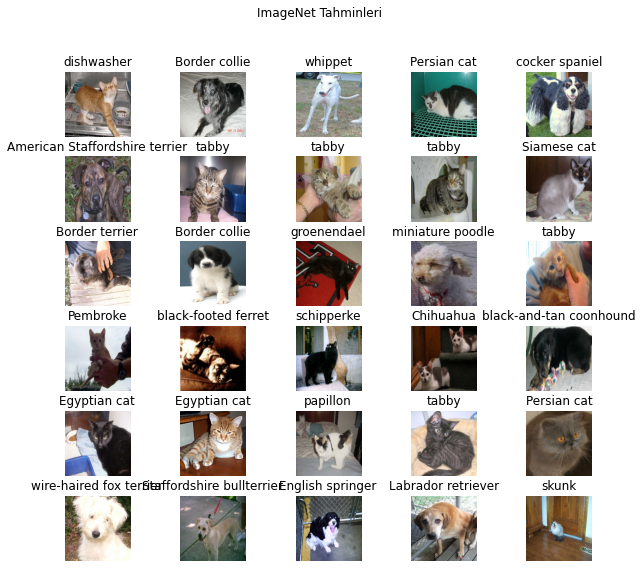

In [25]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet Tahminleri")

## Bölüm 3: TensorFlow Hub ile Basit Aktarım (Transfer) Öğrenimi Yapılması

Aktarım öğrenimi ile önceden eğitilmiş bir modelin parçalarını yeniden kullanırız ve modelin son katmanını veya birkaç katmanını değiştiririz. Ardından bu katmanları kendi veri kümemizle tekrar eğitiriz.

TensorFlow Hub, tamamlanmış modellere ek olarak modelleri son sınıflandırma katmanı olmadan da kullanıcılara sunar. Bunlar aktarım öğrenmeyi kolayca yapmak için kullanılır. MobileNet v2'yi kullanmaya devam ediyoruz. Ufak bir spoiler verelim bu eğitimin ilerleyen kısımlarında bu modeli alıp TensorFlow Lite kullanarak mobil cihazlara dağıtacağız.

Ayrıca Dogs vs Cats veri setini kullanmaya da devam ediyoruz böylece bu modellerin performansını daha önce sıfırdan oluşturduğumuz modeller ile karşılaştırma şansımız olacaktır.

TensorFlow Hub içerisinde barınan kısmı modeli (son sınıflandırma katmanı olmayan model) `feature_extractor` olarak adlandırdığımızı unutmayın. Bu terimin nedeni, girdiyi bir dizi özellik içeren bir katmana kadar götürecek olmasıdır. Bu nedenle, nihai olasılık dağılımını oluşturmak dışında tüm kısmı kısmı modelimiz yapmıi olur. Yani görüntünün özelliklerini çıkarmıştır.

In [26]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Özellik çıkarıcı katmanındaki değişkenleri dondurun, böylece eğitim yalnızca son sınıflandırıcı katmanını değiştirir.

In [27]:
feature_extractor.trainable = False

### Sınıflandırma Başlığının Eklenmesi

Şimdi hub katmanını bir `tf.keras.Sequential` modeli ile sarıyoruz ve yeni bir sınıflandırma katmanı eklliyoruz.

In [28]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Modelin Eğitilmesi

Şimi modelimizi diğer modellerde olduğu gibi `compile` ile derleyin ve `fit` ile eğitin.

In [29]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 47s 66ms/step - loss: 0.0577 - accuracy: 0.9790 - val_loss: 0.0446 - val_accuracy: 0.9852
Epoch 2/6
582/582 [==============================] - 42s 64ms/step - loss: 0.0308 - accuracy: 0.9901 - val_loss: 0.0314 - val_accuracy: 0.9899
Epoch 3/6
582/582 [==============================] - 42s 64ms/step - loss: 0.0249 - accuracy: 0.9913 - val_loss: 0.0306 - val_accuracy: 0.9910
Epoch 4/6
582/582 [==============================] - 42s 65ms/step - loss: 0.0219 - accuracy: 0.9923 - val_loss: 0.0315 - val_accuracy: 0.9901
Epoch 5/6
582/582 [==============================] - 42s 64ms/step - loss: 0.0206 - accuracy: 0.9925 - val_loss: 0.0324 - val_accuracy: 0.9895
Epoch 6/6
582/582 [==============================] - 42s 65ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 0.0331 - val_accuracy: 0.9908


Yaklaşık olarak %97 doğrulama seti doğruluğu elde ettiğimizi görebilirsiniz. Bu kesinlikle oldukça güzel bir başarı. Bu, önceki colab dosyasında oluşturduğumuz modelin doğruluk değerinden gözle görülür derece de yüksek. Bu farklılığın nedeni, MobileNet'in uzmanlar tarafından uzun bir süre boyunca özenle tasarlanmış ve daha sonra büyük bir veri kümesi (ImageNet) üzerinden eğitilmiş olmasıdır.

TensorFlow Hub'a eş değer olmasa da, Keras'ta MobileNet'in nasıl oluşturulacağını [bu](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py) linkten kontrol edebilirsiniz.

Eğitim ve doğrulama veri setimiz için doğruluk/kayıp grafiklerini çizelim.

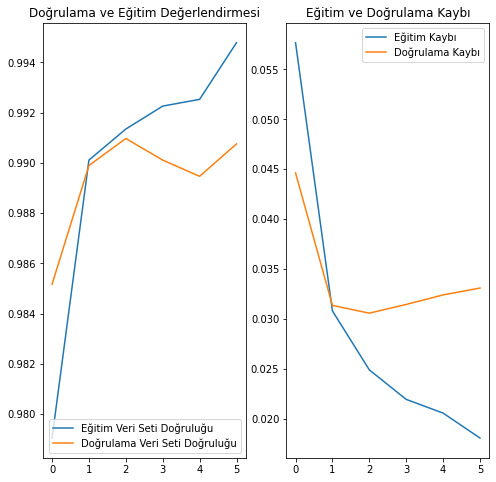

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Veri Seti Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Veri Seti Doğruluğu')
plt.legend(loc='lower right')
plt.title('Doğrulama ve Eğitim Değerlendirmesi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

Burada bizi meraklandırması gereken şey, doğrulama performansının yürütmenin (eğitimin) başından sonuna kadar eğitim performansından daha iyi olmasıdır.

Bunun bir nedeni, doğrulama performansının dönemin sonunda ölçülmesi ancak eğitim performansının dönem boyunca ortalama değerler olmasıdır.

Ancak asıl neden, Köpekler ve Kediler görüntüleri üzerinde zaten eğitilmiş olan MobileNet'in büyük bir bölümünü yeniden kullanıyor olmamızdır. Eğitim yaparken, ağ hala eğitim görüntülerinde veri seti büyütme gerçekleştirir, ancak doğrulama veri kümesinde yapmaz. Bu, doğrulama veri setindeki normal görüntülere kıyasla eğitim görüntülerinin sınıflandırılmasının daha zor olabileceği anlamına gelir.

### Tahminlerin Kontrol Edilmesi

Çizimi yaparken daha kolay olması için sıralı olarak sınıf adlarını alalım.


In [33]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [34]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat',
       'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat',
       'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog',
       'dog', 'dog', 'cat', 'cat', 'dog'], dtype='<U3')

Hadi şimdi gerçek etiketlere ve tahmin edilen etiketlerimize bakalım

In [35]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1]
Predicted labels:  [0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1]


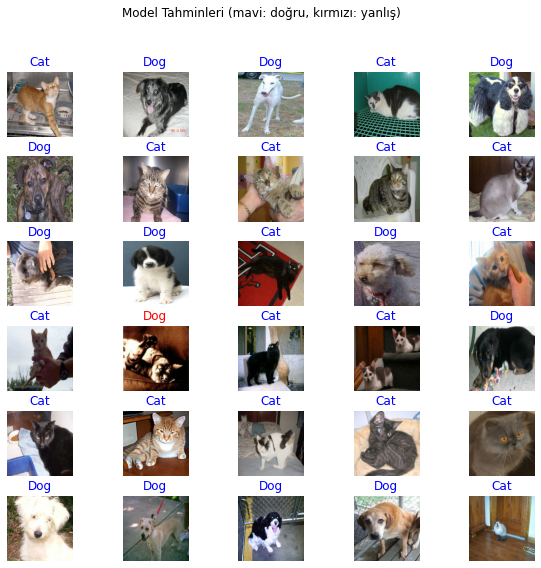

In [37]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model Tahminleri (mavi: doğru, kırmızı: yanlış)")